ABSTRACT


In [ ]:
import pandas as pd

train_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

DATA PREPARATION

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
    df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
    df = df[df["Sex"] != "."]
    df = df.dropna()
    y = le.transform(df["Species"])
    df = df.drop(["Species"], axis = 1)
    df = pd.get_dummies(df, dtype = float)
    return df, y


X_train, y_train = prepare_data(train)

X_train

EXPLORE: Create two visualizations of the data and one summary table.
    - Include axis labels and legends.
    - Help you draw conclusions about what features you are going to try using for your model.
    - Be accompanied by discussion of what you learned and how you will use it in modeling. 

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/palmer-penguins.csv"
df = pd.read_csv(url)

SumTable = df.groupby(['Species', 'Sex']).aggregate({'Body Mass (g)': 'mean'})
SumTable2 = df.groupby(['Species', 'Island']).aggregate({'Culmen Length (mm)': 'mean'})

# Filter to get penguins living on Dream Island
Island_Dream_df = df[df['Island'] == 'Dream']

print(SumTable, SumTable2)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot first scatterplot
sns.scatterplot(data=df, x='Culmen Length (mm)', y='Culmen Depth (mm)', hue= 'Species', ax=axes[0])
axes[0].set_title('Scatterplot 1')

# Plot second scatterplot
sns.scatterplot(x='Culmen Length (mm)', y='Culmen Depth (mm)', data= Island_Dream_df, hue= 'Species', ax=axes[1])
axes[1].set_title('Scatterplot 2')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

FEATURE SELECTION: 

In [26]:
from itertools import combinations
import numpy as np

# Alternative tools to select features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Types of models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Optimizing max_depth
from sklearn.model_selection import GridSearchCV

# Cross validation
from sklearn.model_selection import cross_val_score

# Qualitative and quantitative columns I've selected
all_qual_columns = ["Island_Biscoe", "Island_Dream", "Island_Torgersen", "Stage_Adult, 1 Egg Stage","Clutch Completion_No", "Clutch Completion_Yes", "Sex_FEMALE", "Sex_MALE" ]
all_quant_columns = ["Culmen Length (mm)", "Culmen Depth (mm)", "Flipper Length (mm)", "Body Mass (g)", "Delta 15 N (o/oo)", "Delta 13 C (o/oo)"]

LR = LogisticRegression(max_iter = 1000)  

clf = DecisionTreeClassifier(random_state=0)
parameters = {'max_depth': np.arange(1, 21)}

all_cols = []

for qual in all_qual_columns: 
    qual_cols = [col for col in X_train.columns if qual in col] 
    for pair in combinations(all_quant_columns, 2):
        cols =  list(pair) + qual_cols 

        # Linear Regression Model

        LR.fit(X_train[cols], y_train)
        LR_accuracy = LR.score(X_train[cols], y_train)
        cv_scores_LR = cross_val_score(LR, X_train[cols], y_train, cv = 5)

        # Decision Tree Classifier Model

        grid_search = GridSearchCV(clf, parameters, cv = 5)
        grid_search.fit(X_train[cols], y_train)
        best_clf = grid_search.best_estimator_
        best_params = grid_search.best_params_
        dt_accuracy = best_clf.score(X_train[cols], y_train)
        cv_scores_DecisionTree = cross_val_score(best_clf, X_train[cols], y_train, cv = 5)
        
        if (dt_accuracy == 1.0):
            print(f"Features: {cols}, LR Accuracy: {LR_accuracy}, DT Accuracy: {dt_accuracy}, Best Params: {best_params}")
        


Features: ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island_Dream'], LR Accuracy: 0.99609375, DT Accuracy: 1.0, Best Params: {'max_depth': 5}
Features: ['Body Mass (g)', 'Delta 13 C (o/oo)', 'Island_Dream'], LR Accuracy: 0.82421875, DT Accuracy: 1.0, Best Params: {'max_depth': 8}
Features: ['Culmen Length (mm)', 'Body Mass (g)', 'Sex_FEMALE'], LR Accuracy: 0.97265625, DT Accuracy: 1.0, Best Params: {'max_depth': 7}
Features: ['Culmen Length (mm)', 'Body Mass (g)', 'Sex_MALE'], LR Accuracy: 0.97265625, DT Accuracy: 1.0, Best Params: {'max_depth': 7}


TESTING

In [27]:
test_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)
test_clf = DecisionTreeClassifier(random_state=0, max_depth= 7)
X_test, y_test = prepare_data(test)   


test_cols = ['Culmen Length (mm)', 'Body Mass (g)', 'Sex_MALE', 'Sex_FEMALE']


test_clf = test_clf.fit(X_test[test_cols], y_test)


Test_score = test_clf.score(X_test[test_cols], y_test)


In [28]:
X_test[test_cols]

,Culmen Length (mm),Body Mass (g),Sex_MALE,Sex_FEMALE
0,41.7,4700.0,0.0,1.0
1,50.7,4050.0,1.0,0.0
2,38.1,3425.0,0.0,1.0
3,39.6,3550.0,0.0,1.0
4,43.3,4400.0,0.0,1.0
...,...,...,...,...
64,42.5,3350.0,0.0,1.0
65,54.3,5650.0,1.0,0.0
66,59.6,6050.0,1.0,0.0
67,36.9,3500.0,0.0,1.0


PLOTTING DECISION REGIONS

In [29]:
from matplotlib.patches import Patch

def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (7, 3))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1], 
            title = qual_features[i])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
      
      plt.tight_layout()

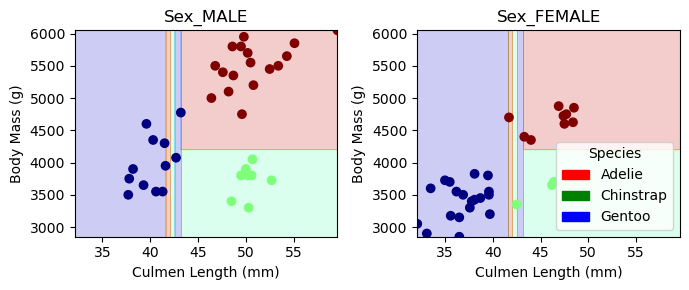

In [30]:
plot_regions(test_clf, X_test[test_cols], y_test)


CONFUSION MATRIX

In [33]:
from sklearn.metrics import confusion_matrix

y_test_pred = test_clf.predict(X_test[test_cols])
C = confusion_matrix(y_test, y_test_pred)
C

array([[31,  0,  0],
       [ 0, 11,  0],
       [ 0,  0, 26]])

DISCUSSION